# In this dataset

1. does it match the statistics of a high dimensional grid representation
2. Is the taurus real
3. test whether you can do the grid realignment like carpenter also in the big maze
4. show that correlation structure is preserved only in as far as cells are spatial


This doesn't make sense you need to take all individual transitions, align them in time and then make this plot.


What we are trying to find out is whether  cells represent space.


If activity is the same across correct and incorrect pokes,

also want to compare discriminability of inter poke period with discriminability of pokes

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 
from scipy.ndimage import gaussian_filter1d
import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)

sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.process_data.proc_beh import get_all_transitions, get_transitions_state, build_poke_df
from mecll.process_data.proc_neural import get_all_resps, get_mean_resps
from mecll.load import load_data
from mecll.SVD_analysis import get_mean_activity_matrix
from mecll.utils import align_activity

In [3]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [4]:
#Load behavioural data
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-07-29_39965_ks25/'
#'/Users/yves/Downloads/example_files2_wOF//'

out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

539 540


In [5]:
#root_path = '/Users/yves/Downloads/example_files2_wOF/'
#out = load_data(root_path,align_to='task')
#spkT,spkC,single_units,events,lines,aligner = out

In [6]:
df = build_poke_df(lines,events)

In [7]:
df['previous_port'][1:] = df['port'][:-1]
df['previous_state'][1:] = df['state'][:-1]

In [8]:
a,b = np.histogram(spkT)

In [9]:
spkT_ms = aligner.A_to_B(spkT)

In [10]:
np.sum(np.isfinite(spkT_ms))/len(spkT)

0.41131170167233166

In [11]:
#poke_dict_t1 ={}
#poke_dict_t2 = {}

dicts = [{} for _ in range(4)]

for port_nr in np.unique(df['state'].values):
    
    kk = 0
    for task_nr in range(2):
        for direction in np.unique(df['direction'].values):
            task_nr = str(task_nr)
            indices = np.where((df['state']==port_nr) &
                               (df['correct']==True) & 
                               (df['direction']==direction) &
                               (df['port_repeat']==False) & 
                               (df['task_nr']==task_nr))[0]
            indices = indices[indices>0]
            v = df.loc[indices]['time'].values.astype('float')
            prev_v = df.loc[indices-1]['time'].values
            #print(direction,df.loc[indices]['state'].values - df.loc[indices-1]['state'].values)

            
            dicts[kk][str(port_nr)] = v
            dicts[kk]['task_nr'] = str(task_nr)
            dicts[kk]['direction'] = str(direction)
            dicts[kk]['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            dicts[kk]['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            kk += 1


In [12]:
#df.loc[:50]

In [14]:
window0 = 3000; window1 = 3000
n_neurons = len(single_units)

n_tasks = 2; n_direction = 2; n_states = 9
all_big_array = np.zeros([n_neurons,n_tasks,n_direction,n_states])


for unit_ix,unit in enumerate(single_units):
        
    spk_unit = spkT[np.where(spkC==unit)[0]] #select all spikes that belong to this cell

    for dict_ix in range(len(dicts)):

        for state_nr in range(9):
            direction = (int(dicts[dict_ix]['direction'])+1)//2
            task_nr = int(dicts[dict_ix]['task_nr'])
            trial_events = np.array(dicts[dict_ix][str(state_nr)])


            aligned_T = aligner.B_to_A(trial_events) #align pokes into spike times

            #get the spikes that are in bounds for position encoding
            pks_unit_in_bounds = np.where(np.logical_not(np.isnan(aligned_T)))[0]

            used_pks = aligned_T[pks_unit_in_bounds].astype('int') #get pokes aligned with spike times
            half_npks = int(len(used_pks)/2)

            #print(key,half_npks)
            n_pokes = 0
            mean_rate = 0
            for pk_ix,tpk in enumerate(used_pks):  #loop over all pokes to a given port
                spike_locs = np.logical_and(spk_unit>(tpk-window0),spk_unit<(tpk+window1))
                mean_rate += 5*np.sum(spike_locs)
                n_pokes += 1
            all_big_array[unit_ix,task_nr,direction,state_nr] = mean_rate/(n_pokes+1e-12)

In [15]:
#AB2 = all_big_array #- np.mean(all_big_array,axis=(1,2,3))[:,None,None,None]
#AB2_resh = AB2.reshape(n_neurons,-1)

In [16]:
AB1 = []
for task in range(2):
    for direction in range(2):
        AB1.append(all_big_array[:,task,direction,:])
AB1 = np.hstack(AB1)

In [17]:
AB2 = AB1 - np.mean(AB1,axis=1)[:,None]

In [19]:
U,S,Vt = np.linalg.svd(AB2)
V = Vt.T

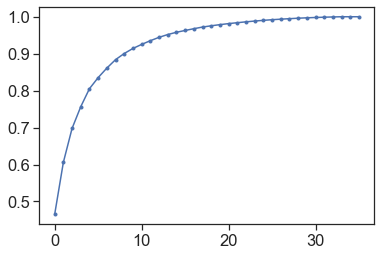

In [20]:
plt.plot(np.cumsum(S**2)/np.sum(S**2),marker='.')

In [91]:
#this should be the first 5 PCs, basically
nDIM = 3
trial_activity = Vt[:nDIM]  #need to check that this is the correct dimension


In [92]:
Y = trial_activity

In [93]:
#Y = trial_activity.reshape(nDIM,2,2,9)

In [94]:
#this is the estimate of the transition matrix, I think
Test = np.linalg.pinv(Y[:,:-1].T).dot(Y[:,1:].T)

In [95]:
Y.shape

(3, 36)

In [96]:
#T_est = 
test_i = []
for i in range(7):
    test_i.append(np.dot(Y[:,i+1].reshape(-1,1),np.linalg.pinv(Y[:,i].reshape(1,-1)).T))

In [97]:
Test_all = np.sum(test_i,axis=0)

In [98]:
Test_all

array([[ 0.2241435 ,  1.84812698,  0.2678706 ],
       [ 0.5700572 ,  2.28898717,  2.05854349],
       [-0.08924282, -0.5496335 , -1.81519308]])

In [122]:
T_est = np.dot(Y[:,1:],
               np.linalg.pinv(Y[:,:-1])
              )

In [123]:
T_est

array([[ 0.3283234 ,  0.05431885,  0.11442027],
       [-0.15195091,  0.35216685,  0.30303659],
       [-0.13641849,  0.11858576, -0.27790093]])

In [124]:
all_pred = []
for i in range(8):
    all_pred.append(np.dot(Test,Y[:,i]))
    print(all_pred[-1])

[ 0.00708205 -0.06552837 -0.01361102]
[ 0.00886518 -0.04958659 -0.07936914]
[-0.03772854  0.05609636  0.02261041]
[0.02945766 0.09775155 0.13659636]
[0.01891391 0.05539436 0.10613984]
[-0.01053857  0.04512544 -0.08834936]
[ 0.01232368 -0.05124449  0.01819324]
[-0.00685437 -0.06084961 -0.08389915]


In [125]:
all_real = []
for i in range(1,9):
    all_real.append(Y[:,i])
    print(all_real[-1])

[-0.01276187 -0.17059671  0.09432096]
[-0.02307599  0.1414909   0.063426  ]
[ 0.1778476   0.28598564 -0.10645115]
[ 0.08822663  0.19021876 -0.13818478]
[ 0.11132291 -0.0084267   0.35456289]
[-0.07060354 -0.07518245 -0.17651884]
[-0.07734618 -0.18416857  0.06923101]
[-0.51143161  0.23492058 -0.07023443]


In [126]:
all_real = np.array(all_real)
all_pred = np.array(all_pred)

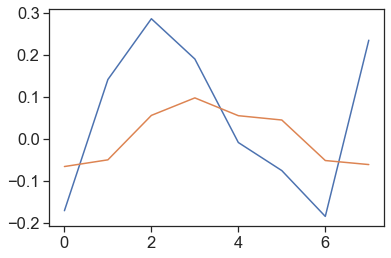

In [129]:
ix = 1
plt.plot(all_real[:,ix])
plt.plot(all_pred[:,ix])

In [104]:

a1 = np.sum(np.dot(U.T,AB2[:,1:9]).dot(all_real).diagonal()**2)

In [110]:
a1

1100.451125449389

In [105]:

a2 = np.sum(np.dot(U.T,AB2[:,1:9]).dot(all_pred).diagonal()**2)

In [107]:
U2,S2,Vt2 = np.linalg.svd(AB2[:,1:9])
#V = V.T

In [108]:
S2

array([149.0074543 ,  77.9038001 ,  59.53876844,  48.7886639 ,
        42.52473805,  39.03297819,  31.27218578,  25.25174381])

In [109]:

a1 = np.sum(np.dot(U.T,AB2[:,19:27]).dot(all_real).diagonal()**2)

In [84]:
AB2.shape

(204, 36)

In [85]:

a2 = np.sum(np.dot(U.T,AB2[:,19:27]).dot(all_pred).diagonal()**2)

In [86]:
a2/a1

0.006384505132835022